In [1]:
using Pkg
pkg"activate ."

In [2]:
using PerlaTonettiWaugh, LinearAlgebra, Plots, BenchmarkTools, Interpolations, QuadGK, DifferentialEquations, BlackBoxOptim, Optim, DataFrames

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

In [3]:
z_min = 0.0 
z_max = 10.
z_grid = unique([range(0., 0.1, length = 400)' range(0.1, 1., length = 400)' range(1., z_max, length = 100)'])
M = length(z_grid)

# Define common objects. 
params = parameter_defaults()
settings = settings_defaults()

d_0 = 3.0700
d_T = 2.5019
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T



# solve for stationary solution at t = 0


stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω
Ω_T = stationary_sol.Ω
settings = (z = z_grid, tstops = nothing, Δ_E = 1e-06)

(z = [0.0, 0.000250627, 0.000501253, 0.00075188, 0.00100251, 0.00125313, 0.00150376, 0.00175439, 0.00200501, 0.00225564  …  9.18182, 9.27273, 9.36364, 9.45455, 9.54545, 9.63636, 9.72727, 9.81818, 9.90909, 10.0], tstops = nothing, Δ_E = 1.0e-6)

## Welfare in steady states

In [4]:
# auxil. function that extracts and displays welfare information from steady state solutions
function display_stationary_sol(stationary_sol)
    @unpack g, z_hat, Ω, π_bar_agg, y, c, λ_ii, U_bar, L_tilde, z_bar, w, x, π_min, r, a, b, S = stationary_sol
    summary_df1 = DataFrame(g = g, z_hat = z_hat, Ω = Ω, π_bar_agg = π_bar_agg, 
                            y = y, c = c, λ_ii = λ_ii)
    summary_df2 = DataFrame(U_bar_0 = U_bar(0.0),
                            L_tilde = L_tilde, z_bar = z_bar, w = w, x = x, π_min = π_min)
    summary_df3 = DataFrame(r = r, a = a, b = b, S = S)
    println(summary_df1)
    println(summary_df2)    
    println(summary_df3)
end;

### Steady state at `T`

In [5]:
display_stationary_sol(stationary_sol)

1×7 DataFrame
│ Row │ g         │ z_hat   │ Ω       │ π_bar_agg │ y       │ c       │ λ_ii     │
│     │ Float64   │ Float64 │ Float64 │ Float64   │ Float64 │ Float64 │ Float64  │
├─────┼───────────┼─────────┼─────────┼───────────┼─────────┼─────────┼──────────┤
│ 1   │ 0.0201157 │ 1.41723 │ 1.29944 │ 0.241359  │ 1.32785 │ 1.32785 │ 0.758212 │
1×6 DataFrame
│ Row │ U_bar_0 │ L_tilde  │ z_bar   │ w       │ x       │ π_min     │
│     │ Float64 │ Float64  │ Float64 │ Float64 │ Float64 │ Float64   │
├─────┼─────────┼──────────┼─────────┼─────────┼─────────┼───────────┤
│ 1   │ 64.4675 │ 0.208646 │ 1.67795 │ 0.42058 │ 1.0     │ 0.0563327 │
1×4 DataFrame
│ Row │ r         │ a       │ b       │ S         │
│     │ Float64   │ Float64 │ Float64 │ Float64   │
├─────┼───────────┼─────────┼─────────┼───────────┤
│ 1   │ 0.0931157 │ 9.4076  │ 0.14236 │ 0.0281562 │


### Steady state at `0`

In [6]:
display_stationary_sol(stationary_sol_0)

1×7 DataFrame
│ Row │ g         │ z_hat   │ Ω       │ π_bar_agg │ y       │ c       │ λ_ii     │
│     │ Float64   │ Float64 │ Float64 │ Float64   │ Float64 │ Float64 │ Float64  │
├─────┼───────────┼─────────┼─────────┼───────────┼─────────┼─────────┼──────────┤
│ 1   │ 0.0104317 │ 1.83737 │ 1.86064 │ 0.26096   │ 1.4463  │ 1.4463  │ 0.900275 │
1×6 DataFrame
│ Row │ U_bar_0 │ L_tilde  │ z_bar   │ w        │ x       │ π_min     │
│     │ Float64 │ Float64  │ Float64 │ Float64  │ Float64 │ Float64   │
├─────┼─────────┼──────────┼─────────┼──────────┼─────────┼───────────┤
│ 1   │ 44.5296 │ 0.190386 │ 1.78641 │ 0.447766 │ 1.0     │ 0.0477907 │
1×4 DataFrame
│ Row │ r         │ a       │ b       │ S          │
│     │ Float64   │ Float64 │ Float64 │ Float64    │
├─────┼───────────┼─────────┼─────────┼────────────┤
│ 1   │ 0.0834317 │ 12.929  │ 0.10122 │ -0.0174171 │


# Transition dynamics

Setup for optimizer:

In [19]:
ENTRY_RESIDUALS_NODES_COUNT = 15
E_NODE_COUNT = 15
SOLUTION = [-0.9283233397558605, -0.7931227777335486, -0.6049356364806617, -0.4927044449099116, -0.3358353090972862, -0.2497406170581776, -0.24267972513426644, -0.1251863870906156, -0.0948087489326721, -0.08776386898955374, -0.05730272455803215, -0.04512884607138278, -0.030714141187059757, -0.03010019595942575, 39.420517045082555]
RANGES_NODES = map(i->(SOLUTION[i] - 1e-5, min(-1e-3, SOLUTION[i] + 1e-5)), 1:(E_NODE_COUNT-1))
RANGES = [RANGES_NODES; (38.999, 40.001)]
WEIGHTS = [fill(15, 3); fill(1, ENTRY_RESIDUALS_NODES_COUNT-3)]
ITERATIONS = 2
SORT_CANDIDATE = true # this will make finding solution much more efficient when we use global optimization schemes

settings_optim = (params_T = params_T, stationary_sol_T = stationary_sol, Ω_0 = Ω_0,
                E_node_count = E_NODE_COUNT, entry_residuals_nodes_count = ENTRY_RESIDUALS_NODES_COUNT, 
                weights = WEIGHTS, ranges = RANGES, iterations = ITERATIONS,
                sort_candidate = SORT_CANDIDATE)
settings = merge(settings, settings_optim);

Find the corresponding solution:

In [33]:
result = solve_full_model_global(SOLUTION, settings);
solved = result.solution;
E_nodes_and_T = result.E_nodes_and_T;

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.71 secs, 2 evals, 1 steps, improv/step: 1.000 (last = 1.0000), fitness=0.006421682
1.44 secs, 4 evals, 2 steps, improv/step: 1.000 (last = 1.0000), fitness=0.006330159

Optimization stopped after 3 steps and 2.1570000648498535 seconds
Termination reason: Max number of steps (2) reached
Steps per second = 1.3908205423298523
Function evals per second = 2.7816410846597046
Improvements/step = 1.5
Total function evaluations = 6


Best candidate found: [-0.928323, -0.793123, -0.604936, -0.492704, -0.335835, -0.24268, -0.0877639, -0.249741, -0.125186, -0.0301002, -0.0451288, -0.0948087, -0.0573027, -0.0307141, 39.4205]

Fitness: 0.006330159



In [34]:
println("E_nodes (sorted) : ")
sort(E_nodes_and_T[1:(length(E_nodes_and_T)-1)])

E_nodes (sorted) : 


14-element Array{Float64,1}:
 -0.9283233397558605  
 -0.7931227777335486  
 -0.6049356364806617  
 -0.4927044449099116  
 -0.3358353090972862  
 -0.2497406170581776  
 -0.24267972513426644 
 -0.1251863870906156  
 -0.0948087489326721  
 -0.08776386898955374 
 -0.05730272455803215 
 -0.04512884607138278 
 -0.030714141187059757
 -0.03010019595942575 

In [35]:
println("T: ")
E_nodes_and_T[end]

T: 


39.420517045082555

## Plots for Ω and `entry_residuals`

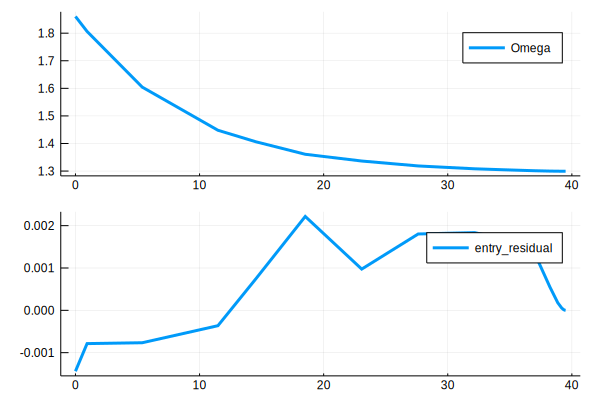

In [22]:
v_t0 = solved.sol.u[1][1:M]
v0 = solved.results[:v_0]
# save v0 and v_hat_t0
v_hat_t0 = map(z -> exp((params.σ-1)*z), z_grid) .* v_t0;

solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

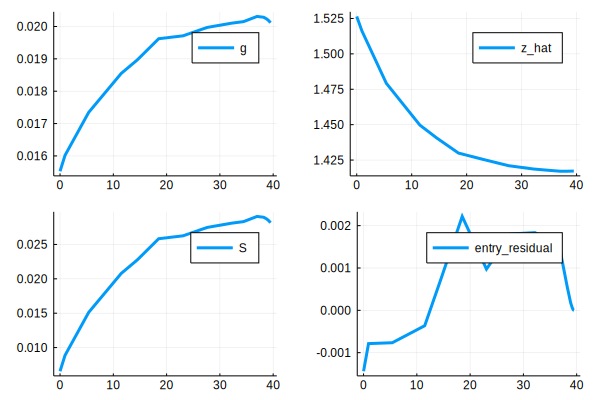

In [23]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

## Static Equations

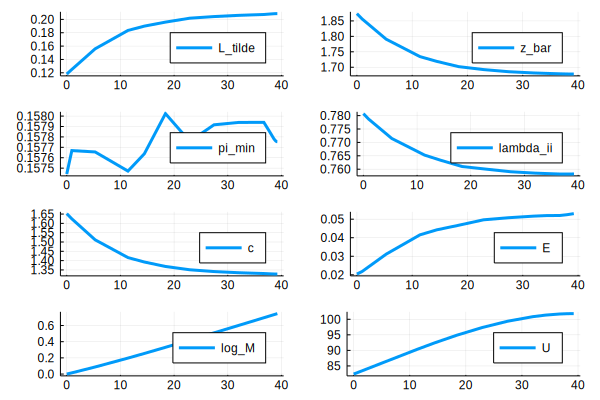

In [12]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(z_grid, v_hat_t0, label = "v_hat at t = 0", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

# Welfare analysis

### `log_M(t)`

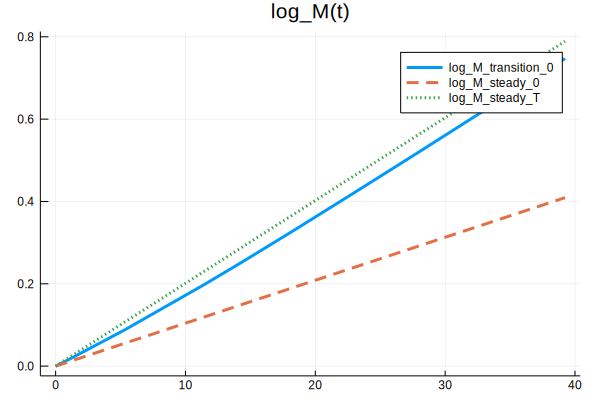

In [13]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

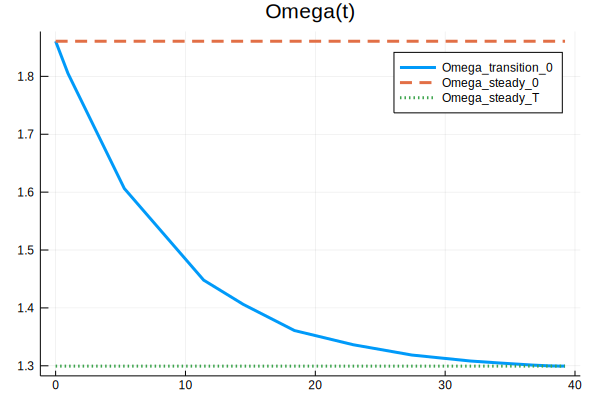

In [14]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

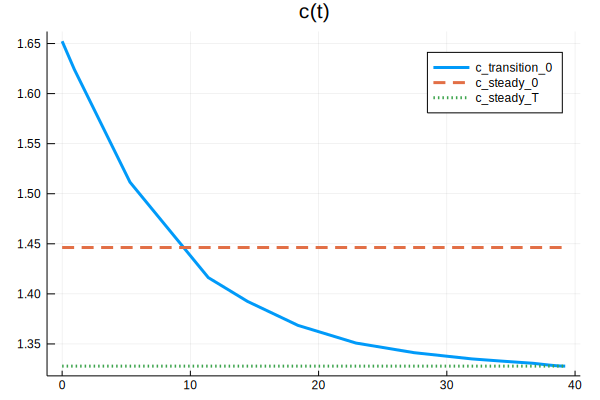

In [15]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

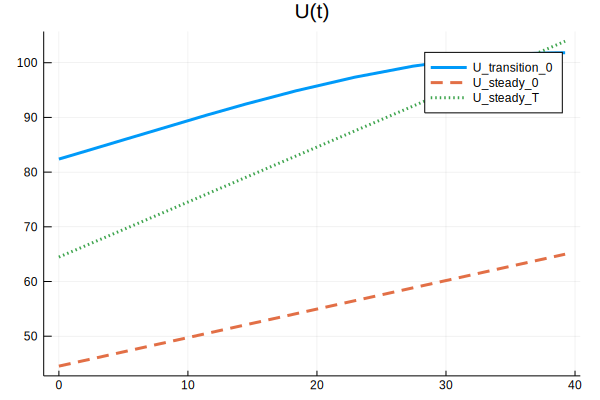

In [16]:
# # define c function (constant)
# ρ = params.ρ
# T = solved.t[end]
# U_steady_0(t) = (ρ*(log(stationary_sol_0.c + stationary_sol_0.g * t)) + stationary_sol_0.g)/(ρ^2)
# U_steady_T(t) = (ρ*(log(stationary_sol.c) + stationary_sol.g * t) + stationary_sol.g)/(ρ^2)
# U_steady_T(t) = (ρ*(log(stationary_sol.c) * stationary_sol.g*t) + stationary_sol.g) / (ρ^2)
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [17]:
 T = solved.t[end]
M_0 = exp(params.ρ*(stationary_sol.U_bar(T) - stationary_sol_0.U_bar(T)))

2.178629459109598

### `M(0)` by autarky and transition from `t=0`

In [18]:
T = solved.t[end]
M_0 = exp(params.ρ*(solved.U[1] - stationary_sol_0.U_bar(T)))

1.4160735193382874